In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7feb1b474cc0>)


/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


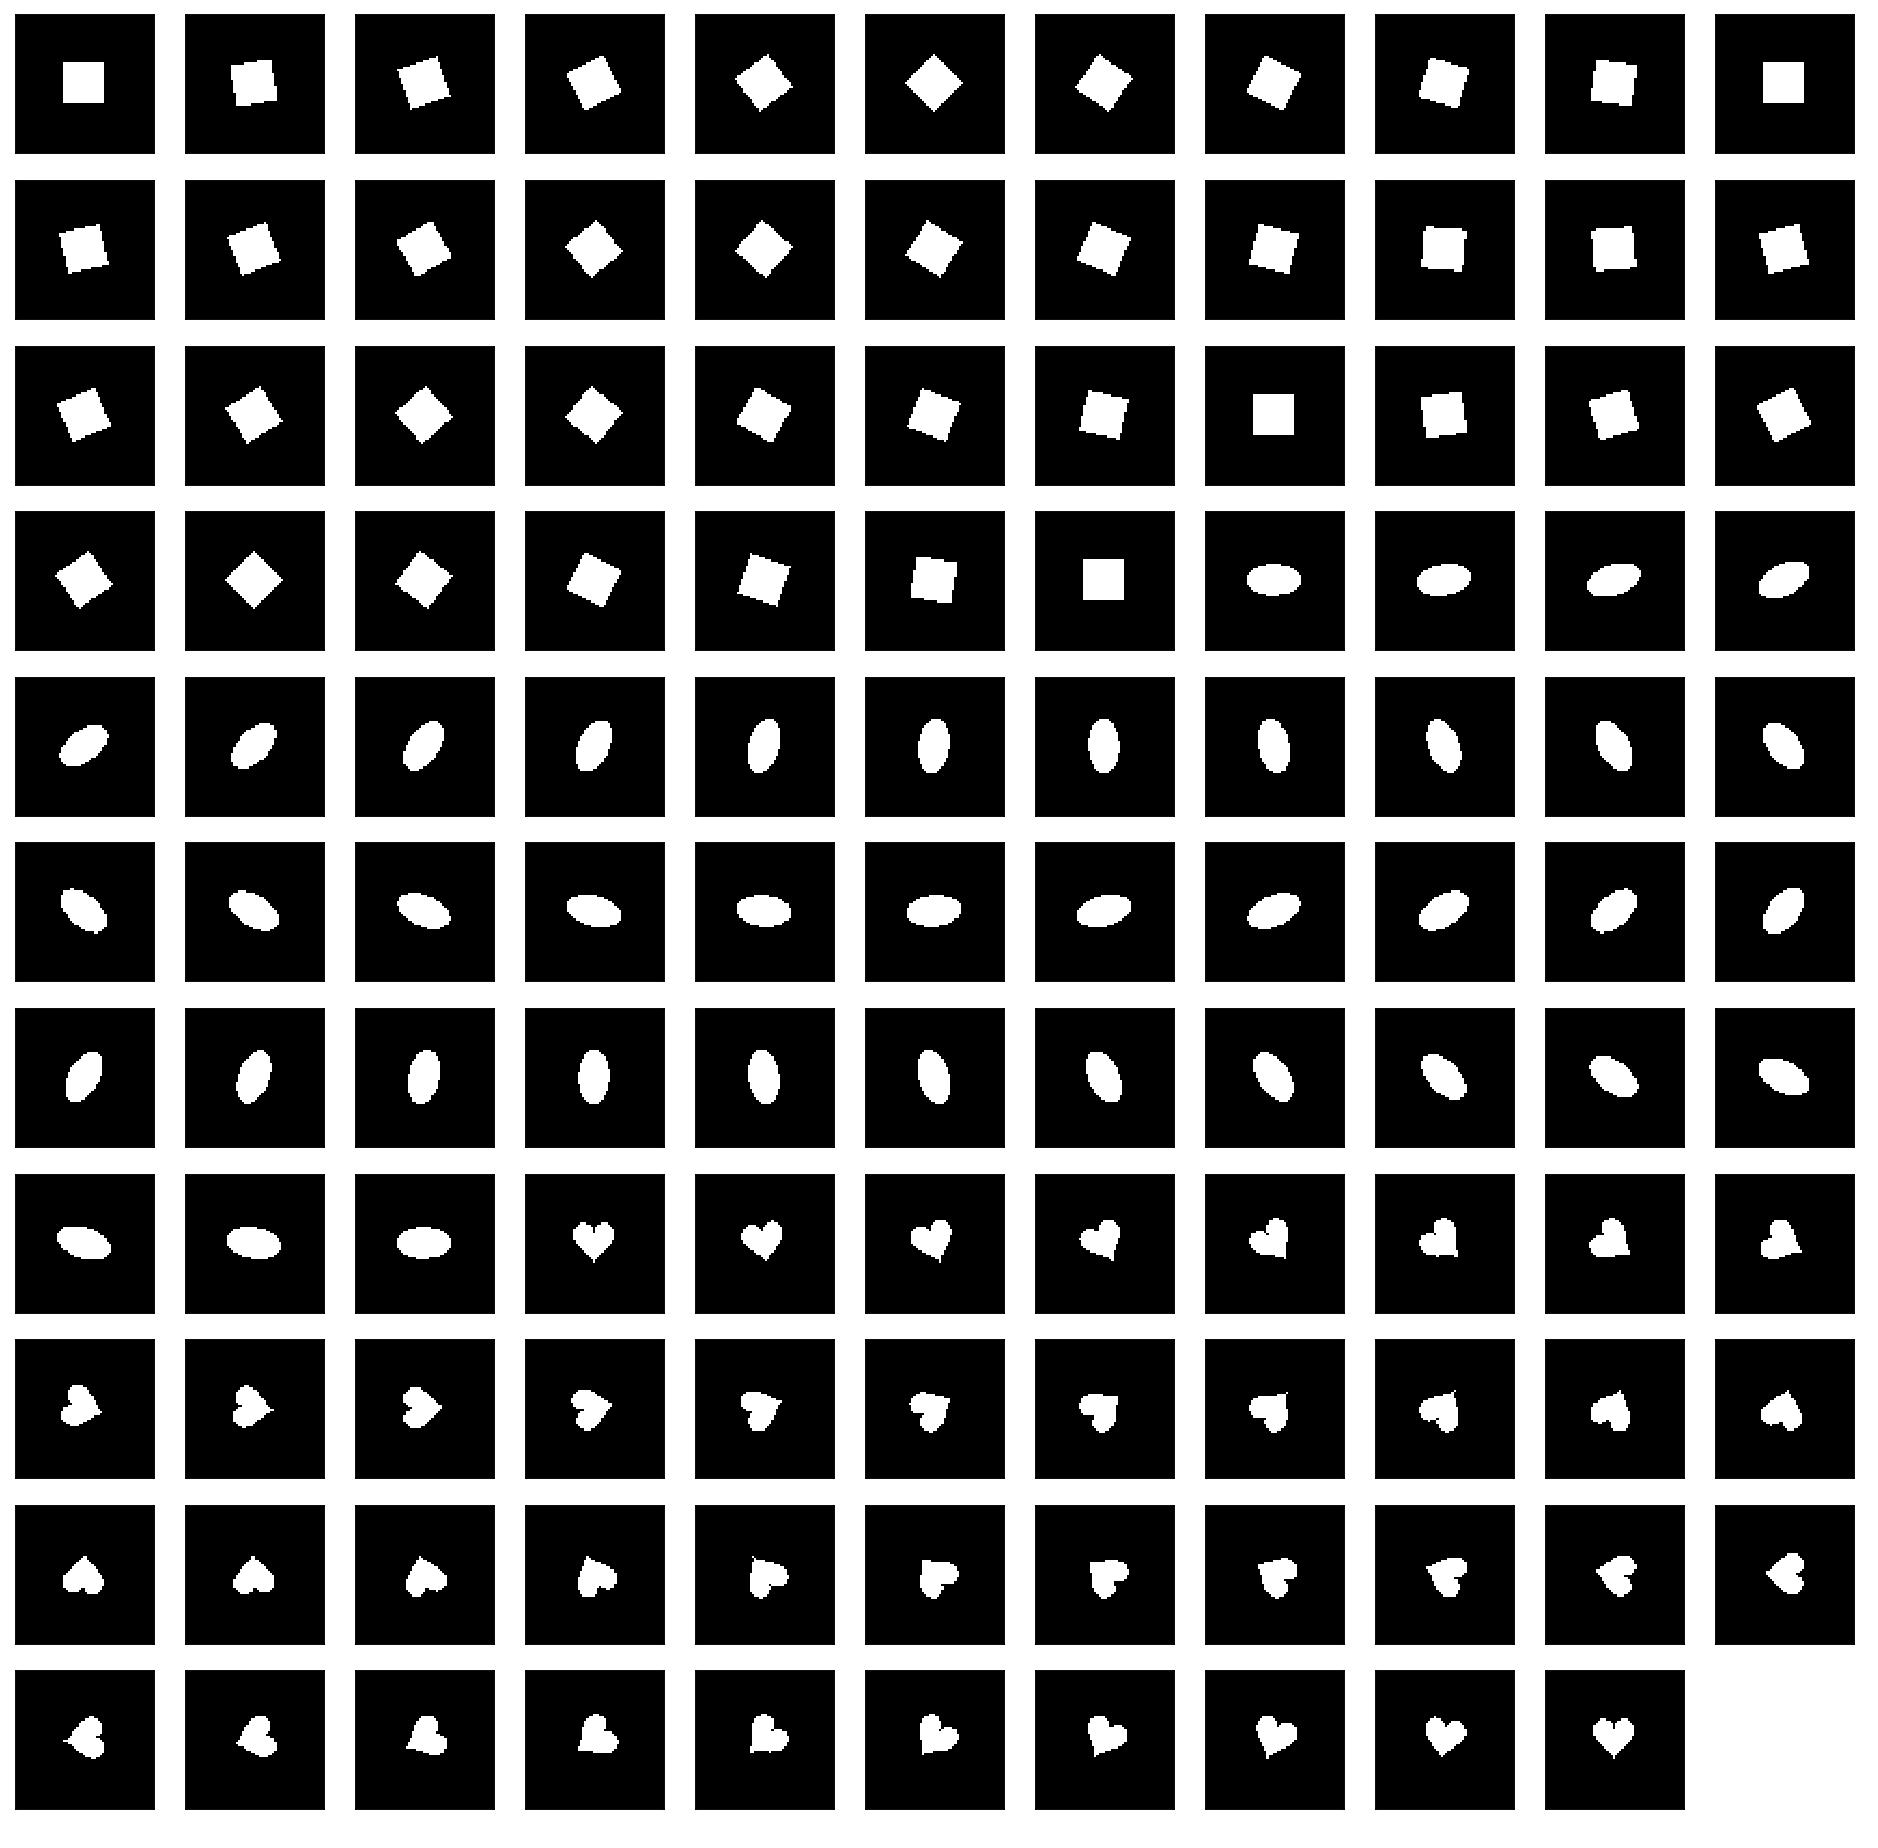

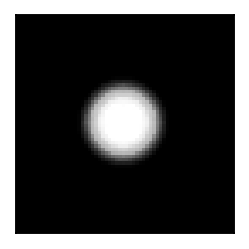

In [2]:
import seaborn as sns

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

# Load dataset
dataset_zip = np.load('dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
                      , encoding='bytes')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

# Define number of values per latents and functions to convert to indices
latents_sizes =  np.array([ 1,  3,  6, 40, 32, 32])
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)

# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

from copy import deepcopy
## Fix posX latent to left
#latents_sampled = sample_latent(size=5000)
latents_sampled = deepcopy(latents_classes)
latents_sampled[:, [4,5]] = 15
latents_sampled[:,2]= 5


indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[np.unique(indices_sampled)]

#np.unique(indices_sampled)

# Samples
show_images_grid(imgs_sampled,len(np.unique(indices_sampled)))

# Show the density too to check
show_density(imgs_sampled)



In [3]:
import random
random.seed(69)
ff = imgs_sampled
n_data =  ff.shape[0]
n_train = int(np.ceil(n_data*0.8))

print(n_train)
idx_train = random.sample(range(n_data), n_train)
idx_test = np.delete(range(n_data),idx_train,0)

96


In [4]:
ff.shape[0]*0.8
idx_test

array([  0,   1,   6,  14,  15,  20,  22,  23,  24,  28,  32,  43,  46,
        51,  55,  67,  85,  92,  93,  96, 104, 105, 110, 118])

In [5]:
# split data into train / validation folds
#np.random.seed(42)

img_rows = ff.shape[1]
img_cols = ff.shape[2]

n_pixels = img_rows * img_cols
x_train = ff[idx_train]
x_test = ff[idx_test]

In [6]:
x_train[1,30]
x_train[1,30].astype('float32')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [7]:
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 
x_train = x_train.reshape((len(x_train), n_pixels))
x_test = x_test.reshape((len(x_test), n_pixels))

In [8]:
x_train.shape

(96, 4096)

In [9]:
x_train[1,2400]

1.0

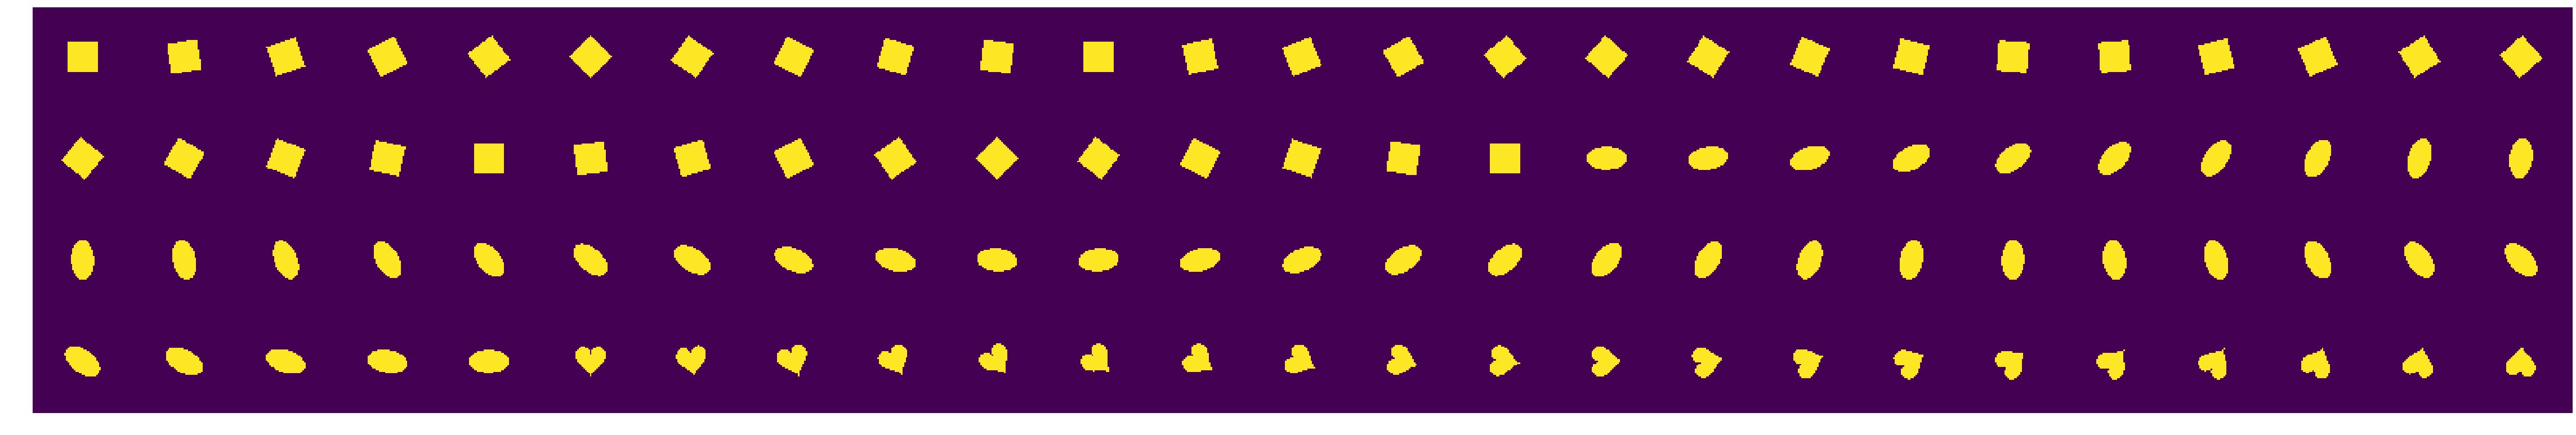

In [10]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(64, 64))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=100, n_cols=25)

In [11]:
import tensorflow as tf
sess = tf.Session()

K.set_session(sess)

In [12]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
#     return z_mean + K.exp(0.5 ) * epsilon

In [13]:
def plot_results(models,
                 latent_dim,
                 latent_num,
                 z_m_m, 
                 batch_size=128,
                 model_name="vae_face"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    #x_test = data
    latent_dim = latent_dim
    os.makedirs(model_name, exist_ok=True)

    
    
    """filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    """

    filename = os.path.join(model_name, "face_over_latent.png")
    n = 20
    #digit_size = 28
    img_rows, img_cols = 64, 64
    figure = np.zeros((img_rows , img_cols * n))
    grid_x = np.linspace(-5, 5, n)
    #grid_y = np.linspace(-5, 5, n)[::-1]
    z_sample = np.zeros((1,latent_dim))
    z_sample[0,:] = z_m_m 
    
    for j, xi in enumerate(grid_x):
        z_sample[0,latent_num] = xi
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_rows, img_cols)
        figure[0: img_rows,j * img_cols: (j + 1) * img_cols] = digit

    plt.figure(figsize=(20, 20))
    #start_range = digit_size // 2
    #end_range = n * digit_size + start_range + 1
    #pixel_range = np.arange(start_range, end_range, digit_size)
    #sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(grid_y, 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='gray')
    plt.savefig(filename)
    plt.show()

In [14]:
# network parameters
original_dim = n_pixels
input_shape = (original_dim, )
intermediate_dim1 = 512
intermediate_dim2 = 256
intermediate_dim3 = 64

batch_size = 20
latent_dim = 3
epochs = 100

In [15]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Dense(intermediate_dim1, activation='relu')(inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x1)
x3 = Dense(intermediate_dim3, activation='relu')(x2)

z_mean = Dense(latent_dim, name='z_mean')(x3)
z_log_var = Dense(latent_dim, name='z_log_var')(x3)


In [16]:
# standardize the mean of z, so that mean(m_z)=0 and cov(m_z)=I
def standardize(z_mean):
    z_m_m = K.mean(z_mean,axis=0, keepdims=True)
    z1 = z_mean - z_m_m
    n = tf.cast(K.shape(z_mean)[0], tf.float32)
    cov = K.transpose(z1) @ z1 /n
    
    D = tf.diag(tf.diag_part(cov)) ** 0.5
    
    L = tf.linalg.inv(tf.transpose(tf.cholesky(cov)))
       
#     z2 = z1 @ L @ D +  z_m_m
    z2 = z1 @ L  +  z_m_m

    return( z2)

In [17]:
# z_mean_std = Lambda(standardize, output_shape=(latent_dim,), name='z_mean_std')(z_mean)

In [18]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           16448       dense_2[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [19]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z')

x3 = Dense(intermediate_dim3, activation='relu')(latent_inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x3)
x1 = Dense(intermediate_dim1, activation='relu')(x2)

# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x1)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 3)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              2101248   
Total params: 2,249,728
Trainable params: 2,249,728
Non-trainable params: 0
_________________________________________________________________


In [20]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [21]:
models = (encoder, decoder)
data = (x_test )

# VAE loss = mse_loss or xent_loss + kl_loss

#     reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 4096)              0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 2245830   
_________________________________________________________________
decoder (Model)              (None, 4096)              2249728   
Total params: 4,495,558
Trainable params: 4,495,558
Non-trainable params: 0
_________________________________________________________________


In [22]:
epochs = int(1E3)

In [23]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 96 samples, validate on 24 samples
Epoch 1/1000
96/96 [==============================] - 1s 9ms/step - loss: 2653.9345 - val_loss: 1599.5410
Epoch 2/1000
96/96 [==============================] - 0s 431us/step - loss: 940.8292 - val_loss: 819.2924
Epoch 3/1000
96/96 [==============================] - 0s 508us/step - loss: 598.0190 - val_loss: 396.1078
Epoch 4/1000
96/96 [==============================] - 0s 524us/step - loss: 320.9387 - val_loss: 292.1827
Epoch 5/1000
96/96 [==============================] - 0s 543us/step - loss: 277.9073 - val_loss: 242.8501
Epoch 6/1000
96/96 [==============================] - 0s 546us/step - loss: 238.4572 - val_loss: 251.1076
Epoch 7/1000
96/96 [==============================] - 0s 536us/step - loss: 236.3686 - val_loss: 237.6793
Epoch 8/1000
96/96 [==============================] - 0s 546us/step - loss: 223.0908 - val_loss: 235.9462
Epoch 9/1000
96/96 [==============================] - 0s 550us/step - loss: 224.5502 - val_loss: 225.6998
Ep

96/96 [==============================] - 0s 519us/step - loss: 137.0182 - val_loss: 156.2261
Epoch 78/1000
96/96 [==============================] - 0s 519us/step - loss: 132.6739 - val_loss: 160.5329
Epoch 79/1000
96/96 [==============================] - 0s 549us/step - loss: 129.8493 - val_loss: 157.0397
Epoch 80/1000
96/96 [==============================] - 0s 540us/step - loss: 129.6615 - val_loss: 155.8911
Epoch 81/1000
96/96 [==============================] - 0s 537us/step - loss: 129.4956 - val_loss: 154.1970
Epoch 82/1000
96/96 [==============================] - 0s 534us/step - loss: 125.8718 - val_loss: 149.6656
Epoch 83/1000
96/96 [==============================] - 0s 536us/step - loss: 120.9229 - val_loss: 149.9258
Epoch 84/1000
96/96 [==============================] - 0s 532us/step - loss: 119.7822 - val_loss: 147.4158
Epoch 85/1000
96/96 [==============================] - 0s 537us/step - loss: 119.5703 - val_loss: 149.6755
Epoch 86/1000
96/96 [==============================

Epoch 154/1000
96/96 [==============================] - 0s 552us/step - loss: 56.4213 - val_loss: 95.1070
Epoch 155/1000
96/96 [==============================] - 0s 542us/step - loss: 57.8476 - val_loss: 92.4582
Epoch 156/1000
96/96 [==============================] - 0s 531us/step - loss: 56.8378 - val_loss: 92.8833
Epoch 157/1000
96/96 [==============================] - 0s 535us/step - loss: 54.7967 - val_loss: 89.7069
Epoch 158/1000
96/96 [==============================] - 0s 542us/step - loss: 50.1841 - val_loss: 92.0569
Epoch 159/1000
96/96 [==============================] - 0s 530us/step - loss: 52.4238 - val_loss: 92.4759
Epoch 160/1000
96/96 [==============================] - 0s 544us/step - loss: 51.4611 - val_loss: 91.3410
Epoch 161/1000
96/96 [==============================] - 0s 535us/step - loss: 49.7871 - val_loss: 88.5892
Epoch 162/1000
96/96 [==============================] - 0s 553us/step - loss: 48.9704 - val_loss: 91.8053
Epoch 163/1000
96/96 [========================

96/96 [==============================] - 0s 531us/step - loss: 35.3098 - val_loss: 85.7912
Epoch 232/1000
96/96 [==============================] - 0s 547us/step - loss: 35.3786 - val_loss: 84.9411
Epoch 233/1000
96/96 [==============================] - 0s 524us/step - loss: 33.9442 - val_loss: 86.1318
Epoch 234/1000
96/96 [==============================] - 0s 544us/step - loss: 33.0735 - val_loss: 95.5061
Epoch 235/1000
96/96 [==============================] - 0s 548us/step - loss: 33.5790 - val_loss: 92.2694
Epoch 236/1000
96/96 [==============================] - 0s 534us/step - loss: 33.7909 - val_loss: 86.9299
Epoch 237/1000
96/96 [==============================] - 0s 557us/step - loss: 32.4181 - val_loss: 88.1658
Epoch 238/1000
96/96 [==============================] - 0s 551us/step - loss: 31.6817 - val_loss: 87.4979
Epoch 239/1000
96/96 [==============================] - 0s 530us/step - loss: 30.3668 - val_loss: 83.9797
Epoch 240/1000
96/96 [==============================] - 0s 54

96/96 [==============================] - 0s 548us/step - loss: 21.4898 - val_loss: 90.1873
Epoch 309/1000
20/96 [=====>........................] - ETA: 0s - loss: 19.2446

KeyboardInterrupt: 

In [24]:
z_output = sess.run( z_mean, feed_dict={'encoder_input: 0':x_train})

In [25]:
z_m_m = np.mean(z_output,axis=0)
z_m_m

array([-0.04715702,  0.15799774, -0.18734579], dtype=float32)

In [26]:
np.cov(z_output.T)

array([[ 2.90831527, -0.28211054, -0.23101112],
       [-0.28211054,  3.58305813, -0.44684098],
       [-0.23101112, -0.44684098,  3.143376  ]])

Plot the Pearson correlation among Z

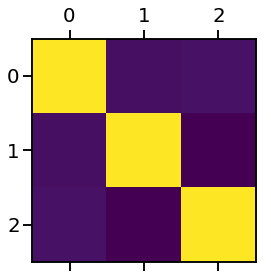

In [27]:
plt.matshow(np.corrcoef(z_output.T))

In [28]:
z_m_m

array([-0.04715702,  0.15799774, -0.18734579], dtype=float32)

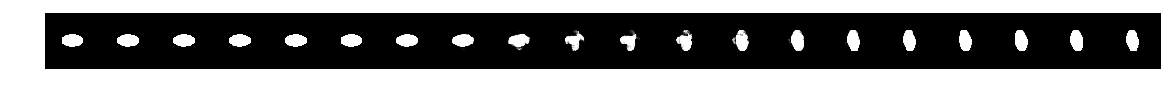

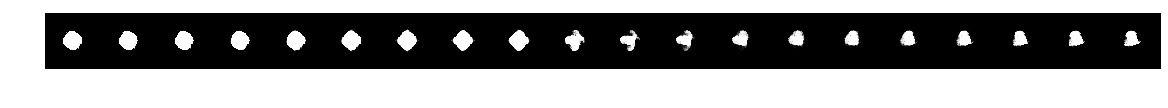

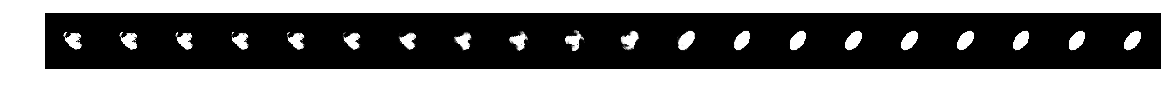

In [29]:
for i in range(0, latent_dim):
    plot_results(models,
                 latent_dim,
                 latent_num = i,
                 z_m_m = z_m_m ,
                 batch_size=batch_size,
                 model_name="vae_mlp")